In [1]:
import pandas as pd

from eoles.utils import get_config, process_heating_need, create_hourly_residential_demand_profile
from eoles.process_cost_efficiency import piecewise_linearization_cost_efficiency
from eoles.model_heat_coupling import ModelEOLES
import logging

from project.model import get_inputs, social_planner  # imports from ResIRF package
import datetime
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# set seaborn style
sns.set_theme()

In [2]:
config = get_config(spec="greenfield")

LOG_FORMATTER = '%(asctime)s : %(name)s  : %(funcName)s : %(levelname)s : %(message)s'
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# consoler handler
console_handler = logging.StreamHandler()
console_handler.setFormatter(logging.Formatter(LOG_FORMATTER))
logger.addHandler(console_handler)

2022-11-28 14:36:06,772 - 39930 - log_ - INFO - Creating AgentBuildings object


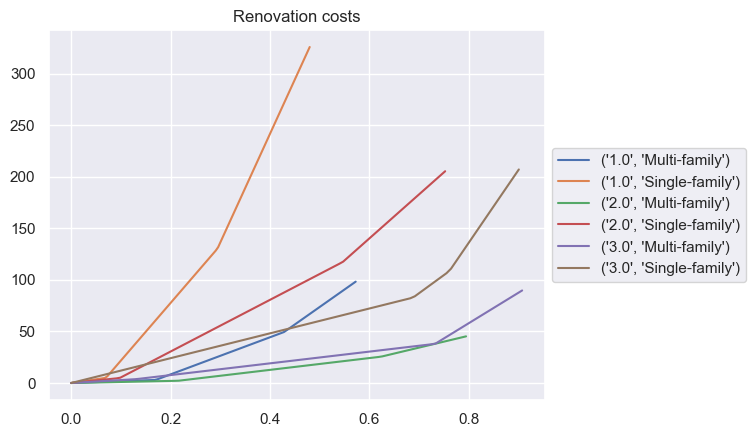

In [3]:
dict_cost, dict_heat = social_planner(aggregation_archetype=['Wall class', 'Housing type'], climate=2006, smooth=False, building_stock="medium_3")
dict_heat = process_heating_need(dict_heat, climate=2006)
linearized_renovation_costs, threshold_linearized_renovation_costs = piecewise_linearization_cost_efficiency(dict_cost, number_of_segments=3, plot=True, plot_tot=True)

2022-11-28 12:16:24,559 - 38879 - log_ - INFO - Creating AgentBuildings object
2022-11-28 12:16:24,559 - 38879 - log_ - INFO - Creating AgentBuildings object


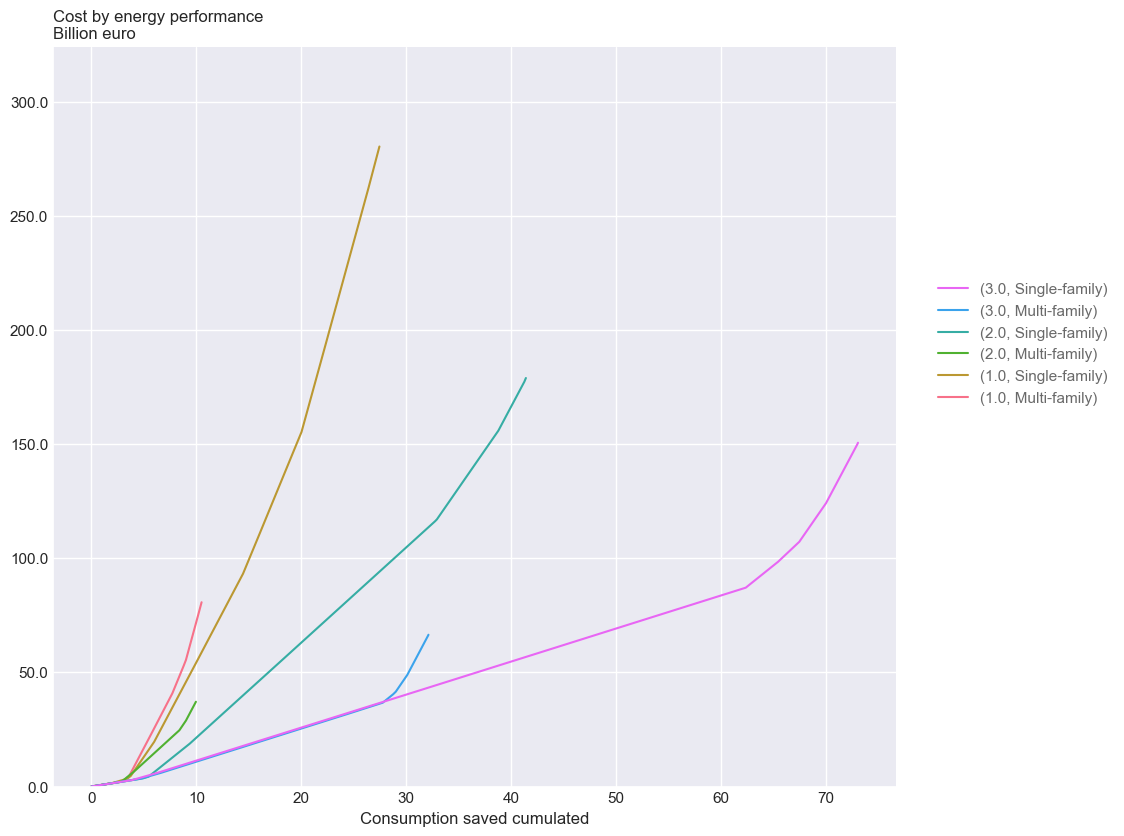

In [5]:
from project.utils import make_plots
dict_cost, dict_heat = social_planner(aggregation_archetype=['Wall class', 'Housing type'], climate=2006, smooth=False, building_stock="medium_3", percent=False)
make_plots(dict_cost, 'Cost by energy performance (Billion euro)', loc="left", left=1.15)

In [5]:
linearized_renovation_costs


Multi-family_0       74.038320
Multi-family_1      339.918501
Multi-family_2      783.122593
Single-family_0     315.485013
Single-family_1    1608.102554
Single-family_2    3523.879720
dtype: float64

In [45]:
[(a, dict_heat[a].sum()) for a in dict_heat.keys()]

[('A', 17.034698284310597),
 ('B', 3627.798307377249),
 ('C', 25248.582353184785),
 ('D', 59477.820497364315),
 ('E', 58277.31138272582),
 ('F', 28672.508101720654),
 ('G', 16697.373641782007)]

In [4]:
list_scc = [0, 100, 200, 300, 400, 500]
list_social_cost = []
list_technical_cost = []
list_emissions = []
list_primary_production = []
list_heat_generation = []
renovation_rate_df = pd.DataFrame()
reindex_primary_prod = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "river", "lake", "nuclear", "methanization", "pyrogazification", "natural_gas"]
reindex_heat_prod = ["resistive", "heat_pump", "gas_boiler", "fuel_boiler", "wood_boiler"]

scenario_cost_high = {
    "capex": {
        "heat_pump": 1500,
        "gas_boiler": 300,
        "resistive": 200,
        "offshore_f": 3600,
        "offshore_g": 2300,
        "nuclear": 5500
    } ,
    "conversion_efficiency": {
        "gas_boiler": 0.75
    },
    "miscellaneous": {
        "max_methanization": 30,
        "max_pyrogazification": 70,
        "CH4_demand": 1.5
    },
    "maximum_capacity": {
        "nuclear": 30
    }
}  # we increase prices to check the impact on the output

# we add hourly heat profile
hourly_gas = create_hourly_residential_demand_profile(total_consumption=18*1e3, method="RTE")
hourly_ECS = pd.Series(6, index=hourly_gas.index)
hourly_CH4_gas = hourly_gas + hourly_ECS

for scc in list_scc:
    print(f"Social cost of carbon: {scc}")
    m_scc = ModelEOLES(name="test", config=config, path="eoles/outputs", logger=logger, nb_years=1, heating_demand=dict_heat, nb_linearize=3,
                       linearized_renovation_costs=linearized_renovation_costs, threshold_linearized_renovation_costs=threshold_linearized_renovation_costs,
                       social_cost_of_carbon=scc, year=2050, scenario_cost=scenario_cost_high, hp_hourly=True, renov=None,
                       hourly_heat_gas=hourly_CH4_gas)
    m_scc.build_model()
    solver_results, status, termination_condition = m_scc.solve(solver_name="gurobi")

    list_social_cost.append(m_scc.objective)
    list_technical_cost.append(m_scc.technical_cost)
    list_emissions.append(m_scc.emissions)

    list_primary_production.append(m_scc.primary_generation.reindex(reindex_primary_prod).to_list())
    list_heat_generation.append(m_scc.heat_generation.reindex(reindex_heat_prod).to_list())
    renovation_rate_df = pd.concat([renovation_rate_df, m_scc.renovation_rates.to_frame().transpose()], axis=0, ignore_index=True)

Social cost of carbon: 0


2022-11-28 14:36:38,665 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-28 14:37:11,320 : __main__  : solve : INFO : Optimization successful


Social cost of carbon: 100


2022-11-28 14:37:26,358 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-28 14:37:51,448 : __main__  : solve : INFO : Optimization successful


Social cost of carbon: 200


2022-11-28 14:38:06,749 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-28 14:38:37,031 : __main__  : solve : INFO : Optimization successful


Social cost of carbon: 300


2022-11-28 14:38:52,395 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-28 14:39:29,798 : __main__  : solve : INFO : Optimization successful


Social cost of carbon: 400


2022-11-28 14:39:45,173 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-28 14:40:19,398 : __main__  : solve : INFO : Optimization successful


Social cost of carbon: 500


2022-11-28 14:40:34,653 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-28 14:41:21,559 : __main__  : solve : INFO : Optimization successful


In [5]:
m_scc.objective

59.394313566942266

In [11]:
m_scc.objective

57.23530006713573

In [8]:
list_social_cost

[2534664.193177706]

In [9]:
sns.set_theme()

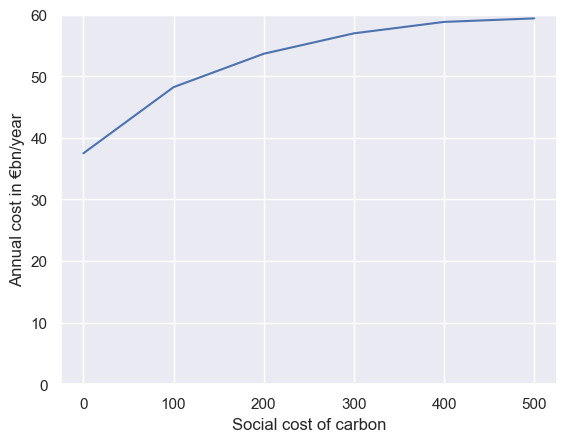

In [6]:
plt.plot(list_scc, list_social_cost)
plt.ylim(0, 60)
plt.ylabel("Annual cost in €bn/year")
plt.xlabel("Social cost of carbon")
plt.show()

In [8]:
m_scc.summary

weighted_price_demand           70.864314
weighted_price_generation       66.541615
elec_demand_tot                561.970000
hydrogen_demand_tot              0.050000
methane_demand_tot              70.560000
heat_demand_tot                192.018429
offshore_f                       0.000000
offshore_g                      92.052931
onshore                        227.556356
pv_g                           120.643922
pv_c                             0.000000
river                           28.482600
lake                            15.302186
methanization                   30.000000
ocgt                             1.392751
ccgt                             1.761506
nuclear                        208.820529
h2_ccgt                         29.758709
phs                             15.765215
battery1                         0.396137
battery4                         2.346426
methanation                      7.740000
pyrogazification                70.000000
electrolysis                    52

In [66]:
m_scc.renovation_annuities

('1.0', 'Multi-family')_0      1129.450387
('1.0', 'Multi-family')_1     11541.946138
('1.0', 'Multi-family')_2     21750.836578
('1.0', 'Single-family')_0     4625.966024
('1.0', 'Single-family')_1    35844.684576
('1.0', 'Single-family')_2    67594.984608
('2.0', 'Multi-family')_0       649.126414
('2.0', 'Multi-family')_1      3671.433510
('2.0', 'Multi-family')_2      7393.833019
('2.0', 'Single-family')_0     3170.527365
('2.0', 'Single-family')_1    16080.522764
('2.0', 'Single-family')_2    27401.970551
('3.0', 'Multi-family')_0      1841.952837
('3.0', 'Multi-family')_1      3650.437324
('3.0', 'Multi-family')_2     18962.943727
('3.0', 'Single-family')_0     7726.001577
('3.0', 'Single-family')_1    22550.453865
('3.0', 'Single-family')_2    45241.091320
dtype: float64

In [65]:
m_scc.capacities

offshore_f           0.000000
offshore_g          20.000000
onshore             80.000000
pv_g                80.473584
pv_c                 0.000000
river                7.500000
lake                12.855000
biogas1              6.741089
biogas2              6.546325
ocgt                12.359572
ccgt                 5.741104
nuclear             30.000000
h2_ccgt             15.819019
phs                  7.200000
battery1             1.105063
battery4             0.483373
methanation          1.395289
pyrogazification     9.688520
electrolysis         9.150300
natural_gas          0.000000
hydrogen            27.758373
methane             98.248895
heat_pump           37.888275
gas_boiler          53.526308
resistive           11.125633
fuel_boiler          0.000000
wood_boiler          0.000000
dtype: float64

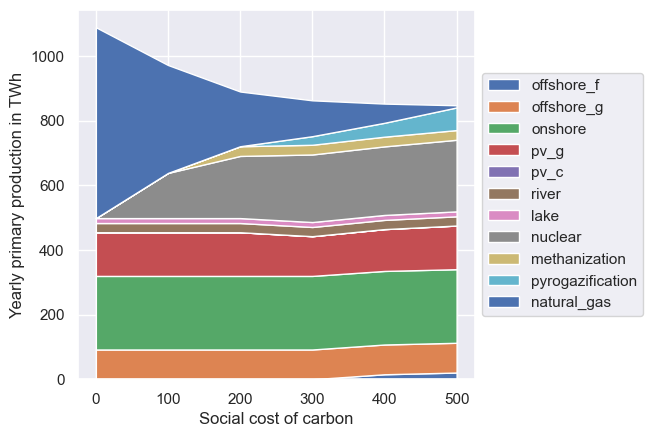

In [8]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

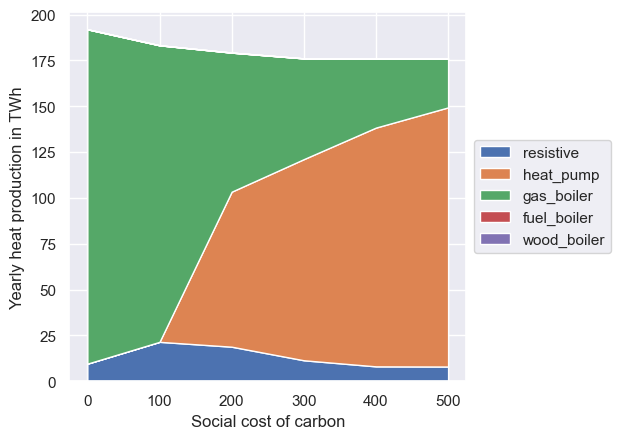

In [9]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [10]:
renovation_rate_df_plot = renovation_rate_df.copy()
renovation_rate_df_plot.index = list_scc
renovation_rate_df_plot = renovation_rate_df_plot.stack(level=[i for i in range(renovation_rate_df_plot.columns.nlevels)]).reset_index()
renovation_rate_df_plot["archetype"] = renovation_rate_df_plot.apply(lambda row: row["level_1"]+ ' ' + row["level_2"], axis=1)
# renovation_rate_df_plot["archetype"] = renovation_rate_df_plot.apply(lambda row: row["level_1"], axis=1)
renovation_rate_df_plot = renovation_rate_df_plot.rename(columns={"level_0": "scc", 0: "renovation_rate"})

In [11]:
renovation_rate_df_plot

,scc,level_1,level_2,renovation_rate,archetype
0,0,1.0,Multi-family,0.000000,1.0 Multi-family
1,0,1.0,Single-family,0.000000,1.0 Single-family
2,0,2.0,Multi-family,0.000000,2.0 Multi-family
3,0,2.0,Single-family,0.000000,2.0 Single-family
4,0,3.0,Multi-family,0.000000,3.0 Multi-family
5,0,3.0,Single-family,0.000000,3.0 Single-family
6,100,1.0,Multi-family,0.169989,1.0 Multi-family
7,100,1.0,Single-family,0.000000,1.0 Single-family
8,100,2.0,Multi-family,0.215389,2.0 Multi-family
9,100,2.0,Single-family,0.000000,2.0 Single-family


In [12]:
df_heat = pd.DataFrame(dict_heat).stack(
    level=[i for i in range(pd.DataFrame(dict_heat).columns.nlevels)]).reset_index()
df_heat["archetype"] = df_heat.apply(lambda row: row["level_1"] + ' ' + row["level_2"], axis=1)  # should be changed depending on level of multiindex
# df_heat["archetype"] = df_heat.apply(lambda row: row["level_1"], axis=1)  # should be changed depending on level of multiindex
df_heat = df_heat.rename(columns={"level_0": "date", 0: "heat_demand"})

df_heat

,date,level_1,level_2,heat_demand,archetype
0,0,1.0,Multi-family,4.318509,1.0 Multi-family
1,0,1.0,Single-family,11.289550,1.0 Single-family
2,0,2.0,Multi-family,2.512364,2.0 Multi-family
3,0,2.0,Single-family,9.320128,2.0 Single-family
4,0,3.0,Multi-family,6.203918,3.0 Multi-family
...,...,...,...,...,...
52555,8759,1.0,Single-family,9.116020,1.0 Single-family
52556,8759,2.0,Multi-family,2.053012,2.0 Multi-family
52557,8759,2.0,Single-family,7.760048,2.0 Single-family
52558,8759,3.0,Multi-family,5.178514,3.0 Multi-family


In [13]:
heat_and_renov = pd.merge(renovation_rate_df_plot.groupby(["archetype", "scc"])["renovation_rate"].sum().reset_index(), df_heat.groupby("archetype")["heat_demand"].sum().reset_index(),
         on='archetype')
heat_and_renov

,archetype,scc,renovation_rate,heat_demand
0,1.0 Multi-family,0,0.000000,17391.601689
1,1.0 Multi-family,100,0.169989,17391.601689
2,1.0 Multi-family,200,0.169989,17391.601689
3,1.0 Multi-family,300,0.169989,17391.601689
4,1.0 Multi-family,400,0.169989,17391.601689
5,1.0 Multi-family,500,0.169989,17391.601689
6,1.0 Single-family,0,0.000000,47283.940315
7,1.0 Single-family,100,0.000000,47283.940315
8,1.0 Single-family,200,0.000000,47283.940315
9,1.0 Single-family,300,0.070003,47283.940315


In [14]:
renov = {}
for n, g in heat_and_renov.groupby('scc'):
    renov.update({n: (g["renovation_rate"] * g["heat_demand"]).sum() / g["heat_demand"].sum()})

In [15]:
renov

{0: 0.0,
 100: 0.04576002491977169,
 200: 0.06634452986476329,
 300: 0.08358260042528023,
 400: 0.08358260042528023,
 500: 0.08358260042528023}

In [48]:
renovation_rate_df_plot.sort_values(by="renovation_rate", ascending=False)

,scc,level_1,level_2,renovation_rate,archetype
20,300,2.0,Multi-family,0.215387,2.0 Multi-family
26,400,2.0,Multi-family,0.215387,2.0 Multi-family
32,500,2.0,Multi-family,0.215387,2.0 Multi-family
8,100,2.0,Multi-family,0.215387,2.0 Multi-family
14,200,2.0,Multi-family,0.215387,2.0 Multi-family
18,300,1.0,Multi-family,0.169994,1.0 Multi-family
24,400,1.0,Multi-family,0.169994,1.0 Multi-family
6,100,1.0,Multi-family,0.169994,1.0 Multi-family
30,500,1.0,Multi-family,0.169994,1.0 Multi-family
12,200,1.0,Multi-family,0.169994,1.0 Multi-family


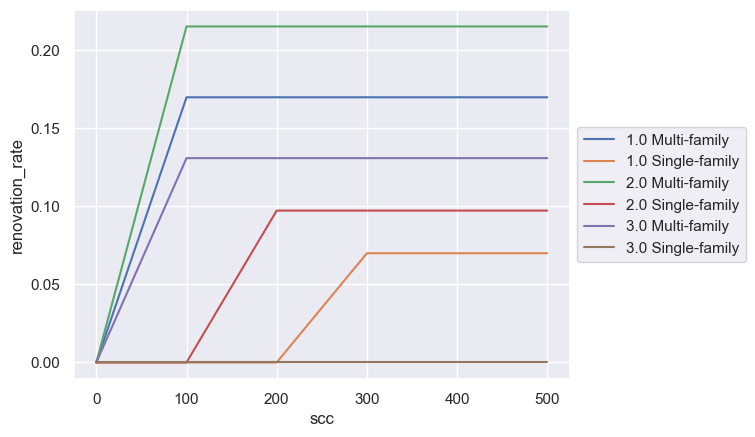

In [16]:
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(renovation_rate_df_plot, x="scc", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

<AxesSubplot:xlabel='scc', ylabel='renovation_rate'>

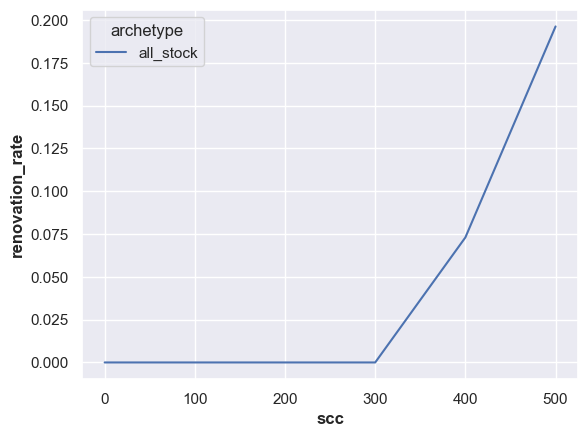

In [48]:
sns.lineplot(renovation_rate_df, x="scc", y="renovation_rate", hue="archetype")